# EE4375: Sixth Lab Session: Galerkin Finite Element Method for the Poisson Equation on the Unit Square 

Memory efficicent and type stable implememtation of before.  

## Import Packages

In [2]:
import Gmsh: gmsh 
using GR 

using LinearAlgebra 
using SparseArrays 
using StructArrays
using StaticArrays
using StaticRanges

using IterativeSolvers
using Preconditioners

using BenchmarkTools
using Profile
using ProfileView

using Plots 

## What to debug next? 

## Section 1: Geometry and Mesh Generation of Unit Square Geometry 
The code that follows performs <b>geometry generation</b> and <b>mesh generation</b> on the unit square geometry. 

In [21]:
#..1/4: initialize gmsh 
gmsh.initialize()

#..2/4: generate geometry 
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("square")
#..set mesh density parameter 
lc = 1.
#lc = 0.001; 
#..define four points via (x,y,z) coordinates 
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
gmsh.model.geo.addPoint(1., 1., 0, lc, 3)
gmsh.model.geo.addPoint(0, 1., 0, lc, 4)
#..define four edges by connecting point labels pairwise  
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
#..define curved loop by connecting four edge labels  
gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
#..define surface by curved loop 
gmsh.model.geo.addPlaneSurface([1], 1)
#..give label to the surface 
#..syntax of the function being used is gmsh.model.setPhysicalName(dim, tag, name) 
gmsh.model.setPhysicalName(2, 1, "My surface")
#..synchronize model 
gmsh.model.geo.synchronize()

#..3/4: generate two-dimensional mesh 
gmsh.model.mesh.generate(2)
#..if true, write mesh to file for further processing 
if (true) gmsh.write("square.msh") end 
#..if true, visualize mesh through the GUI 
if (false) gmsh.fltk.run() end 

#..4/4: finalize gmsh 
gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000424334s, CPU 0.000369s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000228792s, CPU 0.000191s)
Info    : 5 nodes 12 elements
Info    : Writing 'square.msh'...
Info    : Done writing 'square.msh'


## Section 2:/ Read Mesh from file and perform loop over the elements 

### Section 1.3: Using a struct as in the 1D code

In [22]:
# struct to hold 2D point
struct Point
  x::Float64   # x coordinates
  y::Float64   # y coordinates 
end

# struct to hold a single mesh element
struct Element
  p1::Point       # coordinates first node 
  p2::Point       # coordinates second node 
  p3::Point       # coordinates third node     
  e1::Int64       # global index first node
  e2::Int64       # global index second node
  e3::Int64       # global index third node
  area::Float64   # area of the element 
end

# struct to hold entire mesh
struct Mesh
  nnodes::Int64
  nelements::Int64
  Elements::Array{Element,1}
  bndNodeIds::Vector{Int64}
  dofPerElement::Int64       
end 

In [23]:
# function area_triangle(p1::Point,p2::Point,p3::Point)
function area_triangle(p1,p2,p3)    
    x12 = p2.x - p1.x; x13 = p3.x-p1.x;
    y12 = p2.y - p1.y; y13 = p3.y-p1.y;
    area_id = x12*y13 - x13*y12; 
    area_id = abs(area_id)/2.
    return area_id 
end

area_triangle (generic function with 1 method)

In [24]:
p1 = Point(0.,0.); 
p2 = Point(1.,0.); 
p3 = Point(0.,1.); 
area_triangle(p1,p2,p3)
# @code_warntype area_triangle(p1,p2,p3)

0.5

In [25]:
function meshFromGmsh(meshFile) :: Mesh  
    
    #..Initialize GMSH
    gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational
    #..efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..4/12 Get the mesh elements
    #..observe that we get all the two-dimensional triangular elements from the mesh
    element_types, element_ids, element_connectivity = gmsh.model.mesh.getElements(2)
    nelements = length(element_ids[1])
      
    # what does the undef do here? 
    Elements = Array{Element,1}(undef,nelements)

    for element_id in 1:nelements
        e1 = element_connectivity[1][3*(element_id-1)+1]
        e2 = element_connectivity[1][3*(element_id-1)+2]
        e3 = element_connectivity[1][3*(element_id-1)+3]
        p1 = Point(sorted[e1,2], sorted[e1,3])
        p2 = Point(sorted[e2,2], sorted[e2,3])
        p3 = Point(sorted[e3,2], sorted[e3,3])
        area = area_triangle(p1,p2,p3); 
        Elements[element_id] = Element(p1,p2,p3,e1,e2,e3,area)
    end

    #..retrieve boundary nodes by loop over corner point and boundary edges
    node_ids1=[]; node_ids2=[]; node_ids3=[]; node_ids4=[]; 
    node_ids5=[]; node_ids6=[]; node_ids7=[]; node_ids8=[]; 
    node_ids1, node_coord, _ = gmsh.model.mesh.getNodes(0,1)
    node_ids2, node_coord, _ = gmsh.model.mesh.getNodes(0,2)
    node_ids3, node_coord, _ = gmsh.model.mesh.getNodes(0,3)
    node_ids4, node_coord, _ = gmsh.model.mesh.getNodes(0,4)
    node_ids5, node_coord, _ = gmsh.model.mesh.getNodes(1,1)
    node_ids6, node_coord, _ = gmsh.model.mesh.getNodes(1,2)
    node_ids7, node_coord, _ = gmsh.model.mesh.getNodes(1,3)
    node_ids8, node_coord, _ = gmsh.model.mesh.getNodes(1,4)
    bnd_node_ids = union(node_ids1,node_ids2,node_ids3,node_ids4,node_ids5,node_ids6,node_ids7,node_ids8)
    
    #..store inside the mesh 
    dofPerElement = 3
    mesh = Mesh(nnodes,nelements,Elements,bnd_node_ids,dofPerElement) 
    
    #..Finalize gmsh
    gmsh.finalize()
    
    return mesh 
end

function nodesFromGmsh(meshFile)
    
    #..Initialize GMSH
    gmsh.initialize()
    
    #..Read mesh from file
    gmsh.open(meshFile)

    #..Get the mesh nodes
    #..Observe that although the mesh is two-dimensional,
    #..the z-coordinate that is equal to zero is stored as well.
    #..Observe that the coordinates are stored contiguously for computational
    #..efficiency
    node_ids, node_coord, _ = gmsh.model.mesh.getNodes()
    nnodes = length(node_ids)
    #..sort the node coordinates by ID, such that Node one sits at row 1
    tosort = [node_ids node_coord[1:3:end] node_coord[2:3:end]];
    sorted = sortslices(tosort , dims = 1);
    node_ids = sorted[:,1]
    xnode = sorted[:,2]
    ynode = sorted[:,3]

    #..Finalize gmsh
    gmsh.finalize()
    
    return xnode,ynode 
end

nodesFromGmsh (generic function with 1 method)

In [26]:
mesh = meshFromGmsh("square-1.msh")
display(mesh)
typeof(mesh)
display(mesh.Elements)
length(mesh.Elements)
xnode,ynode = nodesFromGmsh("square-1.msh")

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'


Mesh(5, 4, Element[Element(Point(0.0, 0.0), Point(1.0, 0.0), Point(0.5, 0.5), 1, 2, 5, 0.25), Element(Point(0.0, 1.0), Point(0.0, 0.0), Point(0.5, 0.5), 4, 1, 5, 0.25), Element(Point(1.0, 0.0), Point(1.0, 1.0), Point(0.5, 0.5), 2, 3, 5, 0.25), Element(Point(1.0, 1.0), Point(0.0, 1.0), Point(0.5, 0.5), 3, 4, 5, 0.25)], [1, 2, 3, 4], 3)

4-element Vector{Element}:
 Element(Point(0.0, 0.0), Point(1.0, 0.0), Point(0.5, 0.5), 1, 2, 5, 0.25)
 Element(Point(0.0, 1.0), Point(0.0, 0.0), Point(0.5, 0.5), 4, 1, 5, 0.25)
 Element(Point(1.0, 0.0), Point(1.0, 1.0), Point(0.5, 0.5), 2, 3, 5, 0.25)
 Element(Point(1.0, 1.0), Point(0.0, 1.0), Point(0.5, 0.5), 3, 4, 5, 0.25)

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'


([0.0, 1.0, 1.0, 0.0, 0.5], [0.0, 0.0, 1.0, 1.0, 0.5])

In [27]:
# dump(mesh)

In [28]:
xnode,ynode = nodesFromGmsh("square-1.msh")

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'


([0.0, 1.0, 1.0, 0.0, 0.5], [0.0, 0.0, 1.0, 1.0, 0.5])

## Section 3: Perform a FEM Computation  

### Section 1.3: Stiffness Matrix Assembly  

In [32]:
function generateLocalMatrix(element::Element)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    area = element.area 
    Iloc = SVector(e1, e1, e1, e2, e2, e2, e3, e3, e3)
    Jloc = SVector(e1, e2, e3, e1, e2, e3, e1, e2, e3)
    Xmat = SMatrix{3,3}(p1.x, p2.x, p3.x, p1.y, p2.y, p3.y, 1, 1, 1) 
    rhs  = SMatrix{3,3}(1., 0., 0., 0., 1., 0., 0., 0., 1.) 
    Emat = MMatrix{3,3}(Xmat\rhs);
    Emat[3,:] .= 0.;  
    Amat = SMatrix{3,3}(area*(transpose(Emat)*Emat));
    Aloc = [Amat[1,:] ; Amat[2,:] ; Amat[3,:] ] 
    return Iloc, Jloc, Aloc
end

function generateMatrix(mesh::Mesh)
 
    #..recover number of elements  
    N::Int64 = length(mesh.Elements) 
    dofperelem::Int64 = 9;
     
    #..preallocate the memory for local matrix contributions 
    Avalues = zeros(Float64,dofperelem*N)
    I = zeros(Int64,length(Avalues))
    J = zeros(Int64,length(Avalues)) 

    for i = 1:N #..loop over number of elements..
        element          = mesh.Elements[i]
        Iloc, Jloc, Aloc = generateLocalMatrix(element)
        irng             = mrange(dofperelem*i-8, dofperelem*i) 
        I[irng]          = Iloc 
        J[irng]          = Jloc 
        Avalues[irng]    = Aloc         
    end
    
    A = sparse(I,J,Avalues)
   
    return A; 
end

generateMatrix (generic function with 1 method)

In [33]:
mesh = meshFromGmsh("square-1.msh");   A = generateMatrix(mesh); # display(A)

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'


In [34]:
mesh = meshFromGmsh("square-1.msh");   @time generateMatrix(mesh); # <= force recompilation 
mesh = meshFromGmsh("square-1.msh");   @time generateMatrix(mesh); 
mesh = meshFromGmsh("square-10.msh");  @time generateMatrix(mesh); 
mesh = meshFromGmsh("square-100.msh"); @time generateMatrix(mesh); 

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'
  0.000009 seconds (13 allocations: 2.625 KiB)
Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'
  0.000009 seconds (13 allocations: 2.625 KiB)
Info    : Reading 'square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'square-10.msh'
  0.000031 seconds (18 allocations: 103.750 KiB)
Info    : Reading 'square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'square-100.msh'
  0.003446 seconds (23 allocations: 9.510 MiB)


In [35]:
typeof(mesh)

Mesh

In [36]:
#display(mesh.Elements[1])

In [37]:
#display(mesh.bndNodeIds)

In [38]:
Iloc, Jloc, Aloc = generateLocalMatrix(mesh.Elements[1]); 
display(Iloc)
display(Jloc)
display(Aloc)

9-element SVector{9, Int64} with indices SOneTo(9):
  7260
  7260
  7260
   450
   450
   450
 11466
 11466
 11466

9-element SVector{9, Int64} with indices SOneTo(9):
  7260
   450
 11466
  7260
   450
 11466
  7260
   450
 11466

9-element SVector{9, Float64} with indices SOneTo(9):
  0.6940021149974308
 -0.3812300851090914
 -0.3127720298883393
 -0.3812300851090914
  0.5696472233283449
 -0.18841713821925352
 -0.3127720298883393
 -0.18841713821925352
  0.5011891681075928

In [39]:
#@code_warntype generateLocalMatrix(mesh.Elements[1])

### Section 2.3: Mass Matrix Assembly (later)

### Section 3.3: Right-Hand Side Assembly  

In [40]:
sourceFct(x,y) = x+y

sourceFct (generic function with 1 method)

In [41]:
# callable struct allowing type-stable implementation of RHS-vector assembly 
struct SrcFunction{Float64}
    dummy::Float64
end

In [42]:
# source function attached to the callable struct 
function (scrFunction::SrcFunction)(x,y)
    return x+y
end 

In [43]:
mySrcFunction = SrcFunction(0.)

SrcFunction{Float64}(0.0)

In [44]:
mySrcFunction(1,2)

3

In [45]:
function generateLocalVector(element::Element, sourceFct::SrcFunction)
    p1 = element.p1; p2 = element.p2; p3 = element.p3;  
    e1 = element.e1; e2 = element.e2; e3 = element.e3;  
    area = element.area 
    Iloc = SVector(e1, e2, e3) 
    # use broadcast for the lines below instead 
    f1 = area/3*sourceFct(p1.x,p1.y)
    f2 = area/3*sourceFct(p2.x,p2.y)
    f3 = area/3*sourceFct(p3.x,p3.y)
    floc = SVector(f1, f2, f3) 
    return Iloc, floc
end

function generateVector(mesh, sourceFct::SrcFunction)
 
    #..recover number of elements  
    N::Int64 = length(mesh.Elements)
    nnodes = mesh.nnodes 
     
    #..preallocate the memory for local matrix contributions 
    f = zeros(Float64,nnodes)

    for i = 1:N #..loop over number of elements..
        element::Element = mesh.Elements[i]
        Iloc, floc = generateLocalVector(element,sourceFct)
        f[Iloc] += floc 
    end
       
    return f; 
end

generateVector (generic function with 1 method)

In [46]:
f = generateVector(mesh,mySrcFunction)

11833-element Vector{Float64}:
 0.0
 2.4231975485123897e-5
 4.8803387171609125e-5
 2.4401693585828913e-5
 3.9339019913250214e-7
 7.667587030139228e-7
 1.165841385606723e-6
 1.5710936218213712e-6
 2.709380367217487e-6
 2.1847162526161984e-6
 2.9816713271991472e-6
 3.4641016151201457e-6
 3.897114317010688e-6
 ⋮
 0.0001019480386348757
 4.959238992015573e-5
 5.442001798246822e-6
 1.769693479753941e-5
 9.343690649844386e-5
 7.109240636943977e-5
 8.604923377080728e-5
 4.97793745135571e-5
 8.051543262111135e-5
 5.460400136570139e-5
 5.511434192518242e-5
 9.958912650151141e-5

In [47]:
mesh = meshFromGmsh("square-1.msh");   @time generateVector(mesh,mySrcFunction); # <= force recompilation
mesh = meshFromGmsh("square-1.msh");   @time generateVector(mesh,mySrcFunction); 
mesh = meshFromGmsh("square-10.msh");  @time generateVector(mesh,mySrcFunction); 
mesh = meshFromGmsh("square-100.msh"); @time generateVector(mesh,mySrcFunction); 

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'
  0.000009 seconds (1 allocation: 96 bytes)
Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'
  0.000003 seconds (1 allocation: 96 bytes)
Info    : Reading 'square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'square-10.msh'
  0.000004 seconds (1 allocation: 1.219 KiB)
Info    : Reading 'square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'square-100.msh'
  0.000055 seconds (2 allocations: 92.547 KiB)


### Section 4.3: Handle Essential Boundary Conditions 

In [48]:
mesh = meshFromGmsh("square-1.msh");   
A = generateMatrix(mesh); f= generateVector(mesh,mySrcFunction); # <= force recompilation
@time u = generateSolution(mesh,A,f)

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'


LoadError: UndefVarError: generateSolution not defined

In [49]:
function handleBoundary!(mesh,A,f)
    
    bndNodeIds = mesh.bndNodeIds; 
    
    #..handle essential boundary conditions 
    A[bndNodeIds,:] .= 0;
    A[bndNodeIds,bndNodeIds] = Diagonal(ones(size(bndNodeIds)))
    f[bndNodeIds] .= 0;
    return A, f  
end

handleBoundary! (generic function with 1 method)

In [50]:
A,f = handleBoundary!(mesh,A,f)

(sparse([1, 2, 4, 5, 1, 2, 3, 5, 2, 3  …  5, 1, 3, 4, 5, 1, 2, 3, 4, 5], [1, 1, 1, 1, 2, 2, 2, 2, 3, 3  …  3, 4, 4, 4, 4, 5, 5, 5, 5, 5], [1.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0, -1.0, 0.0, 1.0  …  -1.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 4.0], 5, 5), [0.0, 0.0, 0.0, 0.0, 0.3333333333333333])

### Section 5.3: Solve Linear System 

In [51]:
function generateSolution(mesh,A,f)

    A, f = handleBoundary!(mesh,A,f)
    u = A\f 
    return u 
end

u = generateSolution(mesh,A,f) # force compilation 

5-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.08333333333333333

Info    : Reading 'square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'square-10.msh'
Info    : Reading 'square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'square-10.msh'
  0.000050 seconds (19 allocations: 103.797 KiB)
  0.004568 seconds (79 allocations: 301.445 KiB)


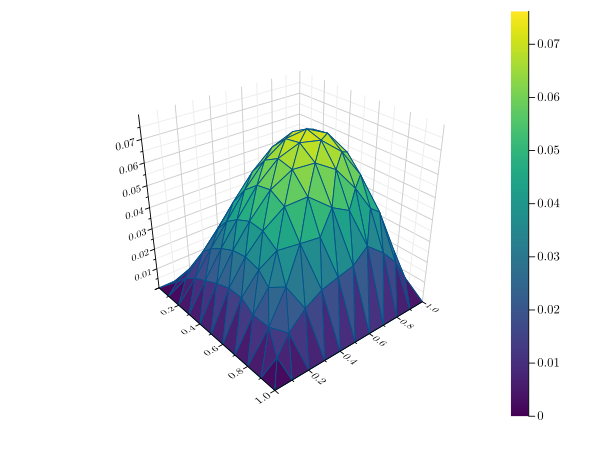

In [53]:
mesh = meshFromGmsh("square-10.msh");  
xnode,ynode = nodesFromGmsh("square-10.msh")
@time A = generateMatrix(mesh); f= generateVector(mesh,mySrcFunction); # <= force recompilation
@time u = generateSolution(mesh,A,f)
GR.trisurf(xnode,ynode,u)

In [54]:
mesh = meshFromGmsh("square-1.msh");   
@time A = generateMatrix(mesh); f= generateVector(mesh,mySrcFunction); # <= force recompilation
@time u = generateSolution(mesh,A,f)

mesh = meshFromGmsh("square-1.msh");   
@time A = generateMatrix(mesh); f= generateVector(mesh,mySrcFunction); 
@time u = generateSolution(mesh,A,f)

mesh = meshFromGmsh("square-10.msh");  
@time A = generateMatrix(mesh); f= generateVector(mesh,mySrcFunction); 
@time u = generateSolution(mesh,A,f)

mesh = meshFromGmsh("square-100.msh"); 
@time A = generateMatrix(mesh); f= generateVector(mesh,mySrcFunction); 
@time u = generateSolution(mesh,A,f)

mesh = meshFromGmsh("square-1000.msh"); 
@time A = generateMatrix(mesh); f= generateVector(mesh,mySrcFunction); 
@time u = generateSolution(mesh,A,f)

Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'
  0.000070 seconds (14 allocations: 2.672 KiB)
  0.000139 seconds (12 allocations: 2.547 KiB)
Info    : Reading 'square-1.msh'...
Info    : 9 entities
Info    : 5 nodes
Info    : 12 elements
Info    : Done reading 'square-1.msh'
  0.000007 seconds (14 allocations: 2.672 KiB)
  0.000010 seconds (12 allocations: 2.547 KiB)
Info    : Reading 'square-10.msh'...
Info    : 9 entities
Info    : 142 nodes
Info    : 286 elements
Info    : Done reading 'square-10.msh'
  0.000037 seconds (19 allocations: 103.797 KiB)
  0.000372 seconds (79 allocations: 301.445 KiB)
Info    : Reading 'square-100.msh'...
Info    : 9 entities
Info    : 11833 nodes
Info    : 23668 elements
Info    : Done reading 'square-100.msh'
  0.003472 seconds (24 allocations: 9.510 MiB)
  0.139013 seconds (88 allocations: 27.141 MiB)
Info    : Reading 'square-1000.msh'...
Info    : 9 entities
Inf

1157393-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0009744498002653742
 0.0003775502626040474
 0.00018604832240482389
 0.0005627265703121411
 0.0001129113097057258
 0.00022181095679295418
 0.00030982583045008013
 0.00012320947696512112
 0.00027835275746595546
 0.0012476520065782951
 0.00017620241452888746
 0.00035681787553605603